In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd
import pyranges as pr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [14]:
%%time
!plink --bfile work/binary/h3a_wgs --recode --out work/slearn/h3a_wgs

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to work/slearn/h3a_wgs.log.
Options in effect:
  --bfile work/binary/h3a_wgs
  --out work/slearn/h3a_wgs
  --recode

192825 MB RAM detected; reserving 96412 MB for main workspace.
1252340 variants loaded from .bim file.
386 people (0 males, 0 females, 386 ambiguous) loaded from .fam.
Ambiguous sex IDs written to work/slearn/h3a_wgs.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 386 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is exactly 1.
1252340 variants and 386 people pass filters and QC.
Note: No phenotypes present.
--recode ped to work/slearn/h

In [7]:
%%time
ped = pd.read_table('work/slearn/h3a_wgs.ped',sep='\s', engine='python', header=None)
ped.shape

<timed exec>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


CPU times: user 19min 28s, sys: 3min 9s, total: 22min 38s
Wall time: 22min 42s


(386, 2504686)

In [8]:
%%time
ped.set_index(ped.iloc[:,0], inplace=True)
ped.drop(columns=[0,1,2,3,4,5], axis=1, inplace=True)
ped=pd.get_dummies(ped)

CPU times: user 1h 12min 16s, sys: 6min 44s, total: 1h 19min 1s
Wall time: 1h 19min 11s


In [9]:
%%time
pca = PCA(n_components=2, svd_solver='full')
ped_pca = pd.DataFrame(pca.fit_transform(ped), columns=['C1', 'C2'])

CPU times: user 5h 54min 12s, sys: 10h 18min 30s, total: 16h 12min 43s
Wall time: 1h 18min 36s


In [10]:
meta = pd.read_table('/data/vcf/h3awgs/samples.meta.tsv', index_col='SampleID')

In [11]:
ped_pca[['Country', 'EthnolinguisticGroup']] = meta[['Country', "EthnolinguisticGroup"]].values

In [15]:
%%time
ped_pca.head()

,C1,C2,Country,EthnolinguisticGroup
0,73.445847,-59.484662,Guinea,Guinea
1,61.554427,-69.922930,Cote D'Ivoire,Cote D'Ivoire
2,95.865141,33.944647,Uganda,Uganda
3,169.495649,40.724971,Uganda,Uganda
4,73.250298,-64.308487,Guinea,Guinea


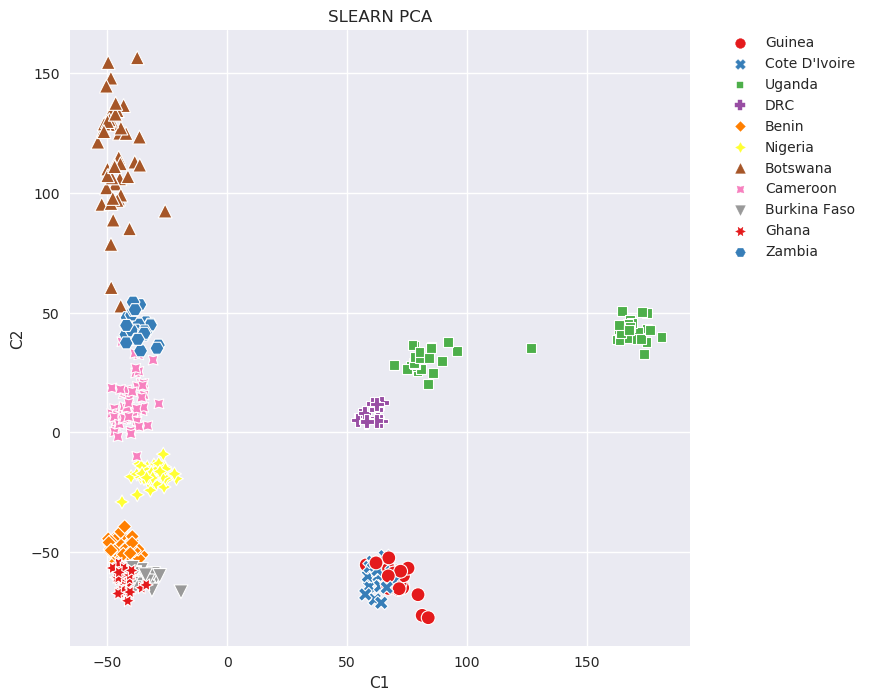

CPU times: user 1.71 s, sys: 206 ms, total: 1.92 s
Wall time: 1.71 s


In [53]:
%%time
plt.style.use("seaborn")
plt.figure(figsize=(8, 8))

ped_pca_plot = sns.scatterplot(
    x='C1',
    y='C2',
    data=ped_pca, 
    hue="Country", 
    style="Country",
    palette="Set1",
    s=100
    )
ped_pca_plot.set_title('SLEARN PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) 
plt.savefig('output/plots/slearn_pca.png', bbox_inches='tight')
plt.show()

In [55]:
kmeans = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=50,
    max_iter=500,
    random_state=42,
).fit(ped_pca.iloc[:,[0,1]])
labels = kmeans.labels_
clusters = pd.DataFrame(kmeans.transform(ped_pca.iloc[:,[0,1]]))
clusters[[2]] = pd.DataFrame(labels).values
clusters[[3]] = ped_pca[['Country']].values
clusters.head()

,0,1,2,3,4
0,140.766264,114.438640,3,Guinea,213.143544
1,138.356101,129.667468,3,Cote D'Ivoire,215.688778
2,135.499553,38.287184,1,Uganda,164.459976
3,209.427764,35.655748,1,Uganda,228.676814
4,143.551983,118.659915,3,Guinea,217.046612


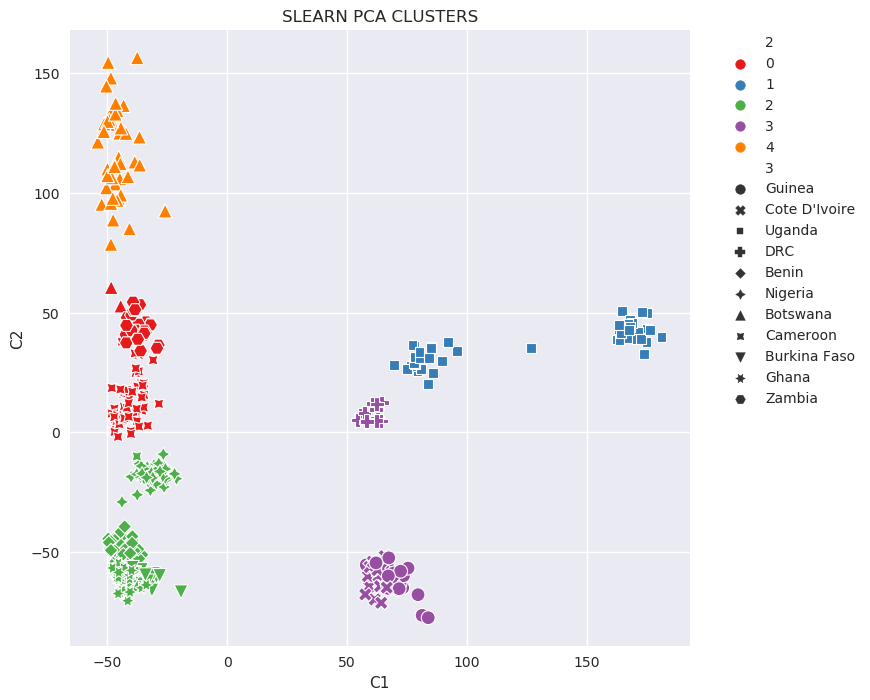

In [56]:
plt.style.use("seaborn")
plt.figure(figsize=(8, 8))

ped_cluster_plot = sns.scatterplot(
    x=ped_pca.iloc[:,0],
    y=ped_pca.iloc[:,1] ,
    data=ped_pca, 
    hue=clusters.iloc[:,2], 
    style=clusters.iloc[:,3],
    palette="Set1",
    s=100
    )
ped_cluster_plot.set_title('SLEARN PCA CLUSTERS')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) 
plt.savefig('output/plots/slearn_pca_clusters.png', bbox_inches='tight')
plt.show()

In [50]:
clusters[5] = meta.index
clusters.head()

,0,1,2,3,4,5
0,140.766264,114.438640,3,Guinea,213.143544,H3A-7C44F2
1,138.356101,129.667468,3,Cote D'Ivoire,215.688778,H3A-B4DD3C
2,135.499553,38.287184,1,Uganda,164.459976,H3A-31F23C
3,209.427764,35.655748,1,Uganda,228.676814,H3A-D3A6FE
4,143.551983,118.659915,3,Guinea,217.046612,H3A-0BF47F


In [51]:
names = {0: 'Alpha', 1: 'Beta', 2: 'Gamma', 3: 'Delta', 4: 'Epsilon'}
clusters[6] = clusters.iloc[:,2].map(lambda x: names.get(x))
clusters.columns = [0,1,2,'Country',4, 'SampleID', 'Cluster']
clusters = clusters[['SampleID', 'Cluster', 'Country']]
clusters.head()

,SampleID,Cluster,Country
0,H3A-7C44F2,Delta,Guinea
1,H3A-B4DD3C,Delta,Cote D'Ivoire
2,H3A-31F23C,Beta,Uganda
3,H3A-D3A6FE,Beta,Uganda
4,H3A-0BF47F,Delta,Guinea


In [52]:
clusters.to_csv('output/cluster/cluster.tsv', sep='\t', header=True, index=False)